

*   Présenter la méthode rapidement :


    1.   Présenter le problème
    2.   Présenter la méthode
    3.   Ecrire les résultats de consistence
    4.   Quels sont les poids optimaux
    5.   Ecrire l'algorithme


*   Utilisation de scikit_learn, expliquer qu'on peut ajouter des poids
*   Ecriture des fonctions de calcul de poids, d'échantillonnage
*   Faire plusieurs types de données
*   Faire des beaux graphiques de comparaison des deux calculs possibles de poids et comparaison avec l'échantillonage uniforme




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression

## Maximum de vraisemblance pour la régression logistique

Dans le cadre de la régression logistique, l'estimation par maximum de vraissemblance n'a pas de forme analytique fermée. Nous sommes donc amenés à estimer ce maximum par des méthodes itératives tels que la descente de gradient ou encore la méthode de Newton-Raphson (on préviligiera cette dernière puisque le calcul de la Hessienne est facile).

Cette démarche fonctionne mais se révèle rapidement inefficace en grande dimension (complexité quadratique en la dimension).

C'est pour pallier à ce problème que HaiYing Wang et al. ont introduit une méthode de sous-échantillonage optimale dans leur article [Optimal Subsampling for Large Sample Logistic Regression](https://ossifragus.github.io/pdfs/OSMAC_Logistic.pdf)


## Méthode de sous-échantillonage optimale



## Fonctions de l'algorithme

In [ ]:
def F(x):
    return 1/(1 + np.exp(-x))

In [ ]:
def getSubSampleAndPis(X_sample, Y_sample, pi, r):
    indexes = np.random.choice(X_sample.shape[0], r, p = pi)
    return X_sample[indexes], Y_sample[indexes], pi[indexes]

In [ ]:
def calculate_pi_mse(x, y, beta):
    n = x.shape[0]

    p = F(x @ beta)
    w = p * (1-p)

    Mx = np.tensordot(x * (w/n)[:, np.newaxis], x, axes = (0,0))
    Mx_inv = np.linalg.inv(Mx)

    A = Mx_inv @ x.T

    norms = np.sqrt(np.sum(A*A, axis = 0))

    num = np.abs(p-y) * norms
    return num / np.sum(num)

In [ ]:
def calculate_pi_vc(x, y, beta):
    p = F(x @ beta)
    w = p * (1-p)
    norms = np.sqrt(np.sum(x*x, axis = 1))
    num = np.abs(p-y) * norms
    return num / np.sum(num)

In [ ]:
def get_beta_tilde(x, y, r0, r1, method, uniform_ssp = True):

    n = x.shape[0]

    if method == "unif":
        x_subsample_unif, y_subsample_unif, _ = getSubSampleAndPis(x, y, np.ones(n)/n, r0+r1)
        return LogisticRegression(fit_intercept = False).fit(x_subsample_unif, y_subsample_unif).coef_[0]

    elif method in ["mse", "vc"]:
        if uniform_ssp:
            x_subsample_0, y_subsample_0, _ = getSubSampleAndPis(x, y, np.ones(n)/n, r0)
            b_tilde_0 = LogisticRegression(fit_intercept = False).fit(x_subsample_0, y_subsample_0).coef_[0]
        else:
            number_ones = y.sum()
            ssp = (y==0)/(2*(n-number_ones)) + (y==1)/(2*number_ones)
            x_subsample_0, y_subsample_0, pi_subsample_0 = getSubSampleAndPis(x, y, ssp, r0)
            b_tilde_0 = LogisticRegression(fit_intercept = False).fit(x_subsample_0, y_subsample_0, 1 / pi_subsample_0).coef_[0]


        if method == "mse":
            pi_tilde = calculate_pi_mse(x, y, b_tilde_0)
        else:
            pi_tilde = calculate_pi_vc(x, y, b_tilde_0)

        x_subsample_tilde, y_subsample_tilde, pi_subsample_tilde = getSubSampleAndPis(x, y, pi_tilde, r1)

        return LogisticRegression(fit_intercept = False).fit(x_subsample_tilde, y_subsample_tilde, 1 / pi_subsample_tilde).coef_[0]

    else:
        raise Exception(f"Unexpected method name : '{method}'")


In [ ]:
def plot_consistency(x_sample, y_sample, uniform_ssp= True):
    norms_unif = []
    norms_vc = []
    norms_mse = []

    Ms = np.linspace(100, n, 100).astype(int)

    for m in Ms:

        r_0 = np.sqrt(m).astype(int)

        r = m - r_0

        hat_beta = LogisticRegression(fit_intercept = False).fit(x_sample[:m], y_sample[:m]).coef_[0]

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "unif")
        norms_unif.append(np.linalg.norm(beta - hat_beta))

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "vc", uniform_ssp)
        norms_vc.append(np.linalg.norm(beta - hat_beta))

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "mse", uniform_ssp)
        norms_mse.append(np.linalg.norm(beta - hat_beta))


    plt.plot(Ms, norms_vc, label = fr" $\pi_i$ vc")
    plt.plot(Ms, norms_mse, label = fr" $\pi_i$ mse")
    plt.plot(Ms, norms_unif, label = fr" $\pi_i$ unif")
    plt.legend();

In [ ]:
def plot_normalite(x_sample, y_sample, uniform_ssp = True):
    beta_tildes = []
    r0 = 200
    r = 8000
    hat_beta = LogisticRegression(fit_intercept = False).fit(x_sample, y_sample).coef_[0]
    pi = calculate_pi_vc(x_sample, y_sample, hat_beta)
    y_F = (y_sample - F(x_sample@hat_beta))**2 / (pi*((len(x_sample)**2)*r))
    Vc =  np.tensordot(x_sample * y_F[:, np.newaxis], x_sample, axes = (0,0))

    f = F(x_sample@hat_beta)*(1-F(x_sample@hat_beta))
    H = - np.tensordot(x_sample * f[:, np.newaxis], x_sample, axes = (0,0))*(1/len(x_sample))
    H_1 = np.linalg.inv(H)
    V = H_1 @ Vc @ H
    for i in range(1000):
        tilde_beta = get_beta_tilde(x_sample, y_sample, r0, r, "vc", uniform_ssp = True)
        beta_tildes.append(tilde_beta.copy())
    aplotter = linalg.sqrtm(H@np.linalg.inv(Vc)@H_1)@((np.array(beta_tildes) - hat_beta).T)
    xx = np.linspace(-4,4,1000)
    fig, axs = plt.subplots(nrows =(d+1)//3 +1*(((d+1)%3)!=0), ncols = 3, figsize = (20,8), sharex = True, sharey = True)
    axs[0][0].set_xlim(-4,4)
    for i in range(d+1):
        axs[i//3][i%3].hist(aplotter[i], density=True, bins ="auto", label = fr"Histogram of $\tilde{{\beta}}_{i}$")
        axs[i//3][i%3].plot(xx, stats.norm.pdf(xx), label = fr"Density of $\mathcal{{N}}(0,1)$")
        axs[i//3][i%3].legend();
    fig.suptitle(fr"Check for asymptotic normality of correctly rescaled $\tilde{{\beta}} - \hat{{\beta}}$")



SyntaxError: unmatched ')' (<ipython-input-9-8e5867b4ff5b>, line 7)

In [ ]:
beta_tilde = plot_normalite()

In [ ]:
def compare_MSE(x_sample, y_sample, r0, r, M = 1000, uniform_ssp = True):
    mse_unif = 0
    mse_vc = 0
    mse_mse = 0
    for _ in range(M):
        beta_unif = get_beta_tilde(x_sample, y_sample, r0, r, "unif")
        beta_vc =  get_beta_tilde(x_sample, y_sample, r0, r, "vc", uniform_ssp)
        beta_mse =  get_beta_tilde(x_sample, y_sample, r0, r, "mse", uniform_ssp)

        mse_unif += np.linalg.norm(beta_unif - true_beta)**2
        mse_vc += np.linalg.norm(beta_vc - true_beta)**2
        mse_mse += np.linalg.norm(beta_mse - true_beta)**2

    return mse_unif/M, mse_vc/M, mse_mse/M

In [ ]:
def plot_MSE_comparison(x_sample, y_sample, r0, ax, uniform_ssp = True):
    mses_unif = []
    mses_vc = []
    mses_mse = []
    Rs = np.linspace(r0, 1000, 10).astype(int)

    for r in Rs:
        mse_unif, mse_vc, mse_mse = compare_MSE(x_sample, y_sample, r0, r, uniform_ssp=uniform_ssp)
        mses_unif.append(mse_unif)
        mses_vc.append(mse_vc)
        mses_mse.append(mse_mse)

    ax.plot(Rs, mses_unif, label = "unif")
    ax.plot(Rs, mses_vc, label = "vc")
    ax.plot(Rs, mses_mse, label = "mse")
    ax.set_xlabel("r")
    ax.set_ylabel("MSE")
    ax.legend();


## Génération des données

In [ ]:
d = 7

true_beta = np.ones(d+1) * 0.5

n = 10000

### Première loi sur les X

In [ ]:
x_loi_1 = stats.multivariate_normal(mean = np.zeros(d), cov = np.ones((d,d)) * 0.5 + np.eye(d)*0.5)
x_sample_1 = np.column_stack((np.ones(n),x_loi_1.rvs(n)))

x_beta_1 = (x_sample_1 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_1) / (1 + np.exp(x_beta_1))

y_sample_1 = (stats.uniform.rvs(size = n) < weights).astype(int)

In [ ]:
beta_tilde = plot_normalite(x_sample_1, y_sample_1)
beta_tilde

###Consistence de $\tilde{β}$ - Premier echantillon

Text(0.5, 1.0, "Consistence de l'estimateur par sous-echantillonage $\\tilde{\\beta}$ - 1-er echantillon - ")

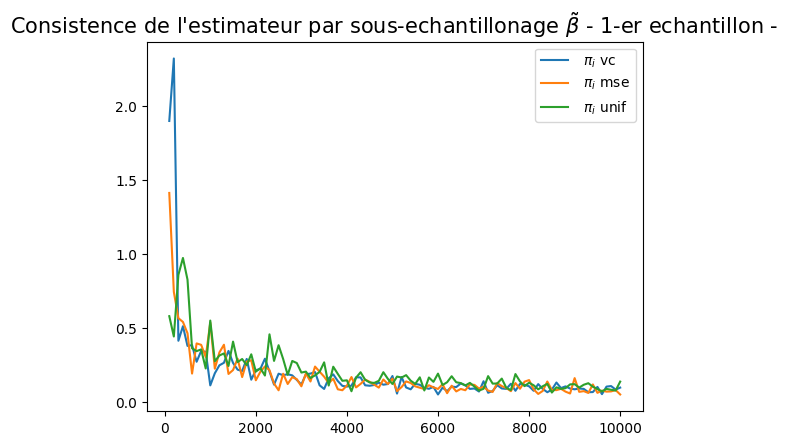

In [ ]:
plot_consistency(x_sample_1, y_sample_1)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 1-er echantillon - ", fontsize = 15)


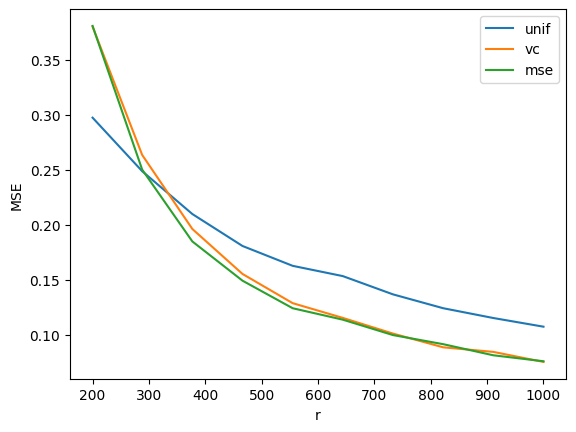

In [ ]:
plot_MSE_comparison(x_sample_1, y_sample_1, 200)

### Deuxième loi sur les X

In [ ]:
x_loi_2 = stats.multivariate_normal(mean = np.zeros(d) + 1.5, cov = np.ones((d,d)) * 0.5 + np.eye(d)*0.5)
x_sample_2 = np.column_stack((np.ones(n),x_loi_2.rvs(n)))

x_beta_2 = (x_sample_2 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_2) / (1 + np.exp(x_beta_2))

y_sample_2 = (stats.uniform.rvs(size = n) < weights).astype(int)


###Consistence de $\tilde{β}$ - Deuxième echantillon

In [ ]:
plot_consistency(x_sample_2, y_sample_2, uniform_ssp = False)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 2-ème echantillon - ", fontsize = 15);


In [ ]:
plot_MSE_comparison(x_sample_2, y_sample_2, 200, False)

### Troisième loi sur les X

In [ ]:
cov_mat = np.outer(1/np.arange(1, d+1), 1/np.arange(1, d+1)) * 0.5 + np.diag(1/np.arange(1, d+1)**2) * 0.5
x_loi_3 = stats.multivariate_normal(mean = np.zeros(d), cov = cov_mat)
x_sample_3 = np.column_stack((np.ones(n),x_loi_3.rvs(n)))

x_beta_3 = (x_sample_3 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_3) / (1 + np.exp(x_beta_3))

y_sample_3 = (stats.uniform.rvs(size = n) < weights).astype(int)

###Consistence de $\tilde{β}$ - Troisième echantillon

In [ ]:
plot_consistency(x_sample_3, y_sample_3)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 3-ème echantillon - ", fontsize = 15);


In [ ]:
plot_MSE_comparison(x_sample_3, y_sample_3, 200)

### Quatrième loi sur les X

In [ ]:
sample_gaus = stats.multivariate_normal(mean = np.zeros(d), cov = np.ones((d,d)) * 0.5 + np.eye(d)*0.5).rvs(n)
sample_bernoul = stats.uniform.rvs(size = n) < 0.5

x_sample_4 = np.column_stack((np.ones(n), (1 - 2 * sample_bernoul)[:,np.newaxis] + sample_gaus))

x_beta_4 = (x_sample_4 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_4) / (1 + np.exp(x_beta_4))

y_sample_4 = (stats.uniform.rvs(size = n) < weights).astype(int)


###Consistence de $\tilde{β}$ - Quatrième echantillon

In [ ]:
plot_consistency(x_sample_4, y_sample_4)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 4-ème echantillon - ", fontsize = 15);


In [ ]:
plot_MSE_comparison(x_sample_4, y_sample_4, 200)

### Cinquième loi sur les X

In [ ]:
x_loi_5 = stats.multivariate_t(loc = np.zeros(d), shape = np.ones((d,d)) * 0.5 + np.eye(d)*0.5 , df = 3)
x_sample_5 = np.column_stack((np.ones(n),x_loi5.rvs(n)/10))

x_beta_5 = (x_sample_5 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_5) / (1 + np.exp(x_beta_5))

y_sample_5 = (stats.uniform.rvs(size = n) < weights).astype(int)


###Consistence de $\tilde{β}$ - Cinquième echantillon

In [ ]:
plot_consistency(x_sample_5, y_sample_5, False)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 5-ème echantillon - ", fontsize = 15);

In [ ]:
plot_MSE_comparison(x_sample_5, y_sample_5, 200, False)

### Sixième loi sur les X

In [ ]:
x_loi_6 = stats.expon(scale = 1/2)
x_sample_6 = np.column_stack((np.ones(n),x_loi_6.rvs((n,d))))

x_beta_6 = (x_sample_6 * true_beta).sum(axis = 1)
weights = np.exp(x_beta_6) / (1 + np.exp(x_beta_6))

y_sample_6 = (stats.uniform.rvs(size = n) < weights).astype(int)



###Consistence de $\tilde{β}$ - Sixième echantillon

In [ ]:
plot_consistency(x_sample_6, y_sample_6)
plt.title(fr"Consistence de l'estimateur par sous-echantillonage $\tilde{{\beta}}$ - 6-ème echantillon - ", fontsize = 15);

In [ ]:
plot_MSE_comparison(x_sample_6, y_sample_6, 200)

In [ ]:
def plot_normalite_ax(x_sample, y_sample,ax, k, uniform_ssp = True):
    beta_tildes = []
    r0 = 200
    r = 8000
    hat_beta = LogisticRegression(fit_intercept = False).fit(x_sample, y_sample).coef_[0]
    pi = calculate_pi_vc(x_sample, y_sample, hat_beta)
    y_F = (y_sample - F(x_sample@hat_beta))**2 / (pi*((len(x_sample)**2)*r))
    Vc =  np.tensordot(x_sample * y_F[:, np.newaxis], x_sample, axes = (0,0))

    f = F(x_sample@hat_beta)*(1-F(x_sample@hat_beta))
    H = - np.tensordot(x_sample * f[:, np.newaxis], x_sample, axes = (0,0))*(1/len(x_sample))
    H_1 = np.linalg.inv(H)
    V = H_1 @ Vc @ H
    for i in range(1000):
        tilde_beta = get_beta_tilde(x_sample, y_sample, r0, r, "vc", uniform_ssp = True)
        beta_tildes.append(tilde_beta.copy())
    aplotter = linalg.sqrtm(H@np.linalg.inv(Vc)@H_1)@((np.array(beta_tildes) - hat_beta).T)
    xx = np.linspace(-4,4,1000)
    fig, axs = plt.subplots(nrows =(d+1)//3 +1*(((d+1)%3)!=0), ncols = 3, figsize = (20,8), sharex = True, sharey = True)
    ax.set_xlim(-4,4)
    ax.hist(aplotter[k], density=True, bins ="auto", label = fr"Histogram of $\tilde{{\beta}}_{k}$")
    ax.plot(xx, stats.norm.pdf(xx), label = fr"Density of $\mathcal{{N}}(0,1)$")
    ax.legend();
    fig.suptitle(fr"Check for asymptotic normality of correctly rescaled $\tilde{{\beta}} - \hat{{\beta}}$")



In [ ]:
def plot_MSE_comparison_ax(x_sample, y_sample, r0, ax, uniform_ssp = True):
    mses_unif = []
    mses_vc = []
    mses_mse = []
    Rs = np.linspace(r0, 1000, 10).astype(int)

    for r in Rs:
        mse_unif, mse_vc, mse_mse = compare_MSE(x_sample, y_sample, r0, r, uniform_ssp=uniform_ssp)
        mses_unif.append(mse_unif)
        mses_vc.append(mse_vc)
        mses_mse.append(mse_mse)

    ax.plot(Rs, mses_unif, label = "unif")
    ax.plot(Rs, mses_vc, label = "vc")
    ax.plot(Rs, mses_mse, label = "mse")
    ax.set_xlabel("r")
    ax.set_ylabel("MSE")
    ax.legend();

In [ ]:
def plot_consistency_ax(x_sample, y_sample, ax, uniform_ssp= True):
    norms_unif = []
    norms_vc = []
    norms_mse = []

    Ms = np.linspace(100, n, 100).astype(int)

    for m in Ms:

        r_0 = np.sqrt(m).astype(int)

        r = m - r_0

        hat_beta = LogisticRegression(fit_intercept = False).fit(x_sample[:m], y_sample[:m]).coef_[0]

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "unif")
        norms_unif.append(np.linalg.norm(beta - hat_beta))

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "vc", uniform_ssp)
        norms_vc.append(np.linalg.norm(beta - hat_beta))

        beta = get_beta_tilde(x_sample[:m], y_sample[:m], r_0, r, "mse", uniform_ssp)
        norms_mse.append(np.linalg.norm(beta - hat_beta))


    ax.plot(Ms, norms_vc, label = fr" $\pi_i$ vc")
    ax.plot(Ms, norms_mse, label = fr" $\pi_i$ mse")
    ax.plot(Ms, norms_unif, label = fr" $\pi_i$ unif")
    ax.legend();

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 3)

x_samples = [x_sample_1,x_sample_2, x_sample_3, x_sample_4, x_sample_5, x_sample_6]
y_samples = [y_sample_1,y_sample_2, y_sample_3, y_sample_4, y_sample_5, y_sample_6]

boolean = [True, False, True, True, True, False]


for i in range(2):
    for j in range(3):
        plot_MSE_comparison_ax(x_samples[i*3 + j], y_samples[i*3 + j], 200, axs[i][j], uniform_ssp = boolean[i*3+j])

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 3)

x_samples = [x_sample_1,x_sample_2, x_sample_3, x_sample_4, x_sample_5, x_sample_6]
y_samples = [y_sample_1,y_sample_2, y_sample_3, y_sample_4, y_sample_5, y_sample_6]

boolean = [True, False, True, True, True, False]

for i in range(2):
    for j in range(3):
        plot_consistency_ax(x_samples[i*3 + j], y_samples[i*3 + j], axs[i][j], uniform_ssp = boolean[i*3+j])

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 3)

x_samples = [x_sample_1,x_sample_2, x_sample_3, x_sample_4, x_sample_5, x_sample_6]
y_samples = [y_sample_1,y_sample_2, y_sample_3, y_sample_4, y_sample_5, y_sample_6]

boolean = [True, False, True, True, True, False]

for i in range(2):
    for j in range(3):
        plot_normalite_ax(x_samples[i*3 + j], y_samples[i*3 + j] , axs[i][j], i+j, uniform_ssp = boolean[i*3+j])